<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras Hub starter guide here: https://keras.io/keras_hub/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available. 

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasHub.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT


In [1]:
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_hub
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow_text

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasHub version:", keras_hub.__version__)

TensorFlow version: 2.16.2
Keras version: 3.9.2
KerasHub version: 0.20.0
TensorFlow text: 2.16.1


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [3]:
df_tweets = pd.read_csv("tweets.csv")

print('Tweets Set Shape = {}'.format(df_tweets.shape))
print('Tweets Set Memory Usage = {:.2f} MB'.format(df_tweets.memory_usage().sum() / 1024**2))

Tweets Set Shape = (7613, 5)
Tweets Set Memory Usage = 0.29 MB


In [4]:
df_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Explore the dataset

In [5]:
df_tweets["length"] = df_tweets["text"].apply(lambda x : len(x))

print("Tweets Length Stat")
print(df_tweets["length"].describe())

Tweets Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


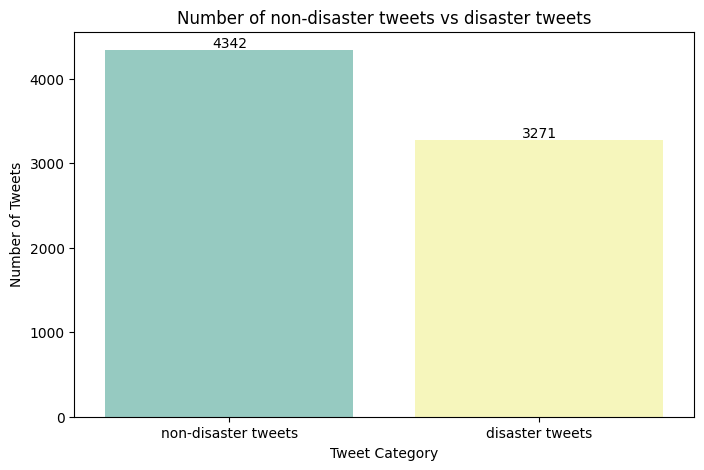

In [6]:
# Count Plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="target", data=df_tweets, palette="Set3", hue="target", legend=False)

for container in ax.containers:
    ax.bar_label(container)

# Set the x-axis tick positions (in this case, we have two categories)
ax.set_xticks([0, 1])  # Positions 0 and 1

# Set the x-axis tick labels
ax.set_xticklabels(['non-disaster tweets', 'disaster tweets'])

ax.set_xlabel('Tweet Category')
ax.set_ylabel('Number of Tweets')
ax.set_title("Number of non-disaster tweets vs disaster tweets")

plt.show()

If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [7]:
BATCH_SIZE = 32
#NUM_TRAINING_EXAMPLES = df_tweets.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
#STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
from sklearn.model_selection import train_test_split

X = df_tweets["text"]
y = df_tweets["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)


# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [9]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_hub.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_hub.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

100%|██████████| 226k/226k [00:00<00:00, 521kB/s]
2025-04-15 11:11:39.628721: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-04-15 11:11:39.628760: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-15 11:11:39.628768: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-15 11:11:39.628803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-15 11:11:39.628817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


100%|██████████| 253M/253M [00:08<00:00, 31.2MB/s] 


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [10]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2


2025-04-15 11:11:54.083061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


191/191 ━━━━━━━━━━━━━━━━━━━━ 126s 556ms/step - accuracy: 0.6856 - loss: 0.5771 - val_accuracy: 0.8359 - val_loss: 0.4000
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 533ms/step - accuracy: 0.8443 - loss: 0.3806 - val_accuracy: 0.8424 - val_loss: 0.3842


In [46]:
y_pred_val = classifier.predict(X_val)
y_pred_val = np.argmax(y_pred_val, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step


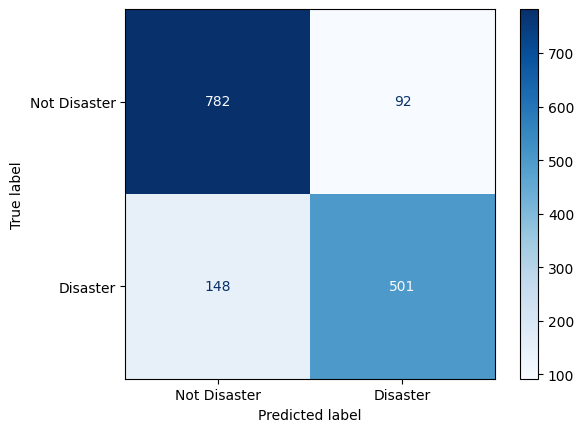

              precision    recall  f1-score   support

Not Disaster       0.84      0.89      0.87       874
    Disaster       0.84      0.77      0.81       649

    accuracy                           0.84      1523
   macro avg       0.84      0.83      0.84      1523
weighted avg       0.84      0.84      0.84      1523



In [47]:
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not Disaster","Disaster"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_val, y_pred_val, target_names=["Not Disaster","Disaster"]))

In [48]:
classifier.save("distilbert_tweets_model.keras")

In [ ]:
classifier = keras.models.load_model('distilbert_tweets_model.keras')
classifier.summary()

/Users/alexia/opt/anaconda3/envs/tf_metal_keras3/lib/python3.9/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/Users/alexia/opt/anaconda3/envs/tf_metal_keras3/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 210 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)